In [2]:
import os, sys, glob
import tarfile
import urllib

import numpy as np
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_figure(output_path, tight_layout=True):
    print('Saving figure:', output_path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig('images/' + output_path, dpi=300)

In [3]:
# download the data

import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    if not os.path.exists(tgz_path):
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
        
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


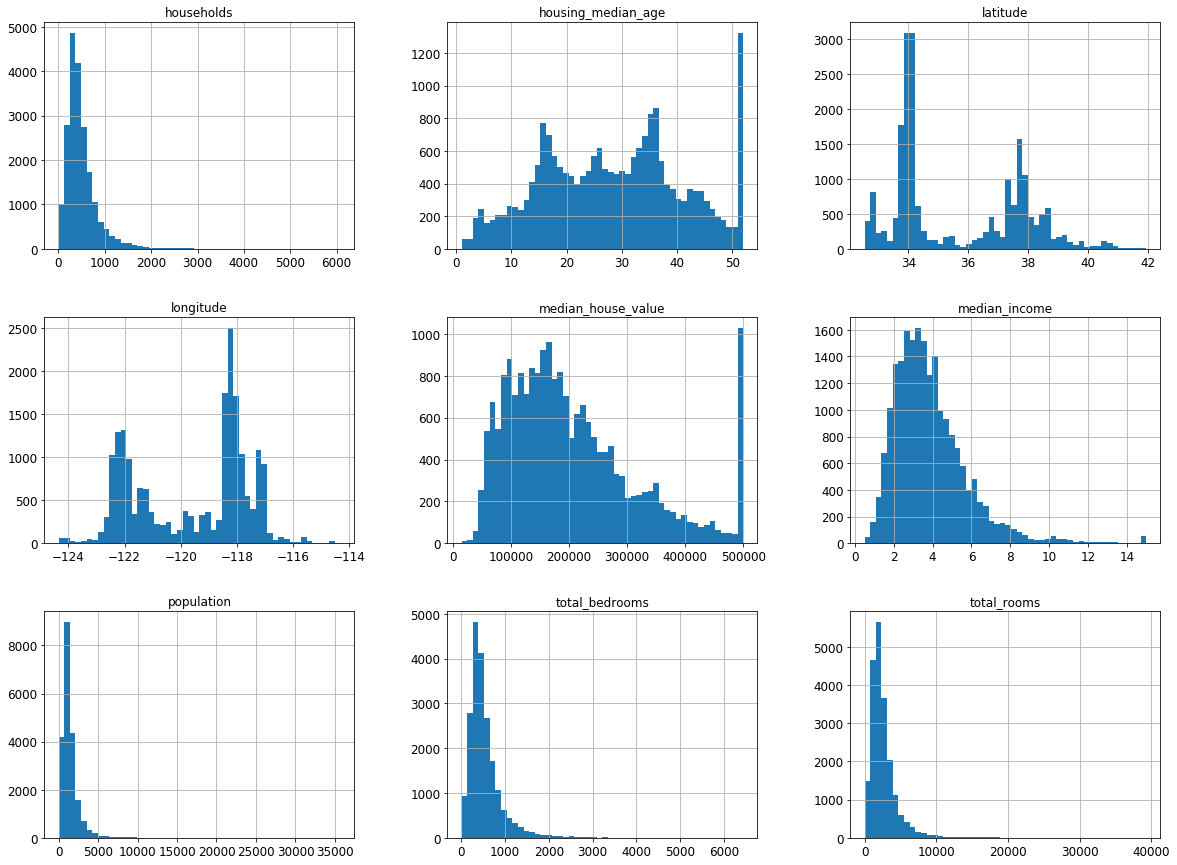

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2**32

# equivelant to sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

housing_with_id = housing.reset_index() # adds an 'index' column
# more stable indices in case we delete rows or add rows inbetween existing rows
# introduces sampling bias however; location is coarse so many districts have the same ID here
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude'] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [19]:
# try to preserve the median_income distribution in train/test sets, since we expect it to be important
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels = [1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

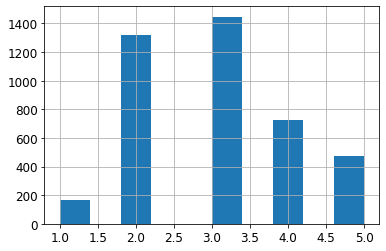

In [24]:
strat_test_set['income_cat'].hist()

In [25]:
for set_ in [strat_train_set, strat_test_set]:
    set_.drop('income_cat', axis=1, inplace=True)

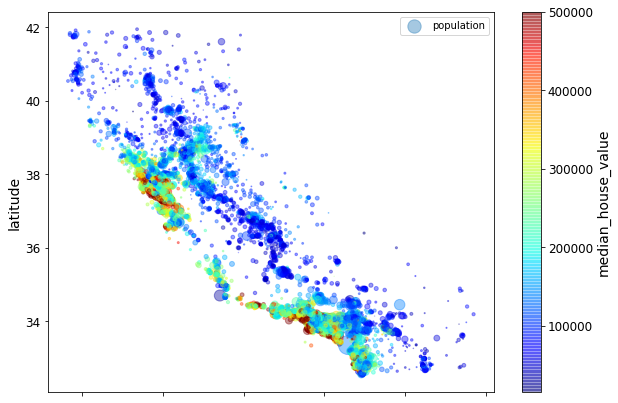

In [37]:
housing = strat_train_set.copy()
housing.plot(kind='scatter', 
              x='longitude', y='latitude', # data to plot
              alpha=0.4, # transparency for each point; more points = darker
              s=housing2['population']/100, # size of each plot
              label='population', figsize=(10,7),
              c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True) # color based on house values
plt.legend()

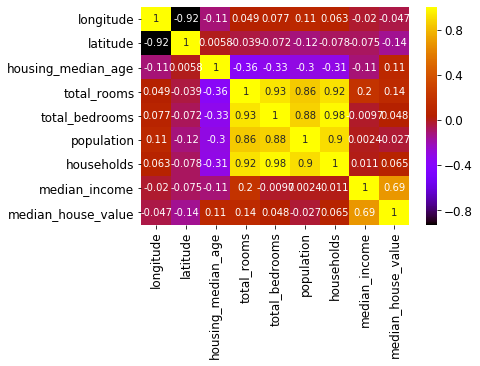

In [38]:
sns.heatmap(housing.corr(), annot=True, cmap='gnuplot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29f22ac8>,
      dtype=object)

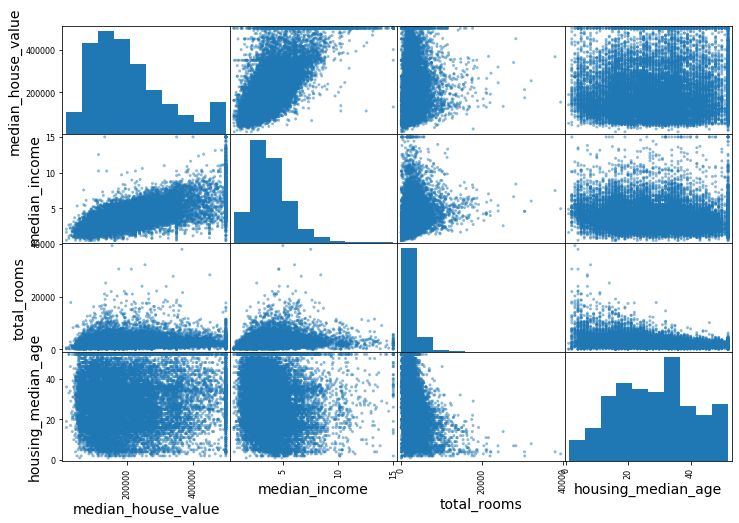

In [40]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']], figsize=(12,8))

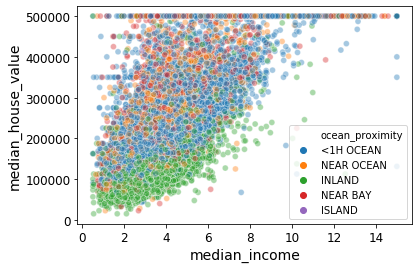

In [41]:
sns.scatterplot(data=housing, x='median_income', y='median_house_value', hue='ocean_proximity', alpha=0.4)

In [43]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [44]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [54]:
# clean up missing info in total_bedrooms
#housing.dropna(subset=['total_bedrooms']) # get rid of rows with bad data
#housing.drop('total_bedrooms', axis=1) # get rid of the entire attribute/column

#median = housing['total_bedrooms'].median() # set na numbers equal to the median value
#housing['total_bedrooms'].fillna(median, inplace=True)

# use sklearn instead to do this; needs only numerical values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)

imputer.statistics_ # same as housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [55]:
X = imputer.transform(housing_num) # fit_transform is faster in some cases, does both fit and transform
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [58]:
# deal with categorical/text attribute
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing[['ocean_proximity']])
housing_cat_encoded[:10]
#ordinal_encoder.categories_

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [61]:
# ordinal representations are stupid however since 0-vs-1 may not be the same "distance" as 2-vs-3
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[['ocean_proximity']])
#housing_cat_1hot.toarray()

In [62]:
# custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [63]:
# transformation pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scale', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [67]:
# full pipeline
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [72]:
# select and train a model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [74]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [78]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

0.0

In [80]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [81]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [67790.84384427 66553.76374727 70361.59333582 68622.492285
 70709.27626994 73633.42618188 72858.03511519 71799.79359178
 76037.39129711 70541.46933619]
Mean: 70890.80850044498
Standard deviation: 2696.396812158726


In [82]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


In [83]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
forest_rmse

18671.44081157724

In [84]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49399.11107247 47383.56725901 49861.08409807 52042.09059368
 49601.77203902 53256.31507703 48647.57590929 47870.58482896
 52893.2907209  50014.16048576]
Mean: 50096.95520841803
Standard deviation: 1918.311269950335


In [86]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [87]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [88]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63633.2619806377 {'max_features': 2, 'n_estimators': 3}
55449.13061160757 {'max_features': 2, 'n_estimators': 10}
52779.1823657892 {'max_features': 2, 'n_estimators': 30}
60987.52402656434 {'max_features': 4, 'n_estimators': 3}
52927.5089518409 {'max_features': 4, 'n_estimators': 10}
50850.414248858644 {'max_features': 4, 'n_estimators': 30}
59952.387547134895 {'max_features': 6, 'n_estimators': 3}
52306.966498208596 {'max_features': 6, 'n_estimators': 10}
50094.82843594871 {'max_features': 6, 'n_estimators': 30}
58780.08640820679 {'max_features': 8, 'n_estimators': 3}
51555.22117275743 {'max_features': 8, 'n_estimators': 10}
50053.21593691657 {'max_features': 8, 'n_estimators': 30}
62158.48004940119 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54691.078484288235 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59952.25318638907 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52118.680647480236 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [91]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.89729337e-02, 6.20570986e-02, 4.42657343e-02, 1.60485186e-02,
       1.43738502e-02, 1.53503477e-02, 1.38215423e-02, 3.47890696e-01,
       6.67383500e-02, 1.11434011e-01, 5.71206675e-02, 6.99390213e-03,
       1.68242459e-01, 9.08619376e-05, 2.47866607e-03, 4.12036054e-03])

In [92]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34789069600689854, 'median_income'),
 (0.16824245911169056, 'INLAND'),
 (0.11143401118711652, 'pop_per_hhold'),
 (0.06897293373544769, 'longitude'),
 (0.066738350010227, 'rooms_per_hhold'),
 (0.06205709856611646, 'latitude'),
 (0.057120667542983214, 'bedrooms_per_room'),
 (0.044265734305199304, 'housing_median_age'),
 (0.01604851861332602, 'total_rooms'),
 (0.01535034772174714, 'population'),
 (0.014373850240488617, 'total_bedrooms'),
 (0.01382154228821466, 'households'),
 (0.006993902127613134, '<1H OCEAN'),
 (0.004120360538366606, 'NEAR OCEAN'),
 (0.0024786660669517025, 'NEAR BAY'),
 (9.086193761280189e-05, 'ISLAND')]

In [95]:
# evaluate on the test set
final_model = grid_search.best_estimator_

import joblib
joblib.dump(final_model, 'final_model.pkl')

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

48006.12772522655

In [99]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46045.03985124, 49890.18844863])